<a href="https://colab.research.google.com/github/jinburge/Congressional-Analytics/blob/main/New_Ages_for_Congressional_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis Comparing Congressional Districts Party Affiliation and Age Groups for White Males


## By Jin Burge (jbburge@calpoly.edu )and Athena Kwok (akwok01@calpoly.edu)

### Feburary 09, 2022

## **Introduction**

This notebook examines the influence of age on political affiliation. Two different age ranges of equal size were used to analyze the differences between our generation and our parent's generation. The ages 20-29 (Gen-z and Millennials) and ages 55-64 (Gen X and Boomers) were selected. A nine year age interval was chosen to represent the majority of ages in MSBA program. Only white males were used to conduct this analysis in order to isolate the age variable and keep ethnicity and gender constant. As of 2022 according to the U.S. Census Bureau, the majority of the US population is white; thus, the majority ethnicity was selected to be used within the analysis. 

**Hypothesis**: In general, the Boomers and Gen X generation (older white males) live in more conservative areas, while Gen-z and Millennials (younger white males) live in more Democratic districts.









## **Data Scraping**

In [ ]:
# read in libraries
import pandas as pd 
import json 
from urllib.request import urlopen 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

First we will read the ACS 2021 dataset and get it into a usable state for our data analysis.

In [ ]:
# We are reading in the data we want from ACS 2021. The API returns json data. Try copy and pasting the link yourself in a browser to see what the raw data looks like.
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B01001A_002E,B01001A_008E,B01001A_009E,B01001A_013E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here: https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name', 'Total White Male', 'White Male 20-24', 'White Male 25-29', 'White Male 55-64', 'State code', 'district number']

# use pandas to parse data 
acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
# extract state, turn district number into numeric (not string)
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

# good to do strip on all data source to get rid of whitespace
# strip removes all that
acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['Total White Male', 'White Male 20-24', 'White Male 25-29', 'White Male 55-64', 'district number', 'State']]

# take a look at the top results in the dataset (first 5)
acs_df

,Total White Male,White Male 20-24,White Male 25-29,White Male 55-64,district number,State
0,318526,16884,17617,52170,10,Michigan
1,263263,16501,14444,37649,4,Mississippi
2,114430,6881,7739,16955,14,Michigan
3,319908,17699,16760,51583,1,Michigan
4,215967,15873,11328,28066,3,Mississippi
...,...,...,...,...,...,...
432,337868,20699,19548,46842,6,Missouri
433,335813,23997,20924,44317,7,Missouri
434,241270,13122,15176,37054,5,Michigan
435,286385,20707,17184,41836,6,Michigan


## **Data Cleaning**

In [ ]:
# Convert the number columns into number data types so we can math on them
acs_df['White Male 20-24'] = pd.to_numeric(acs_df['White Male 20-24'])
acs_df['White Male 25-29'] = pd.to_numeric(acs_df['White Male 25-29'])
acs_df['White Male 55-64'] = pd.to_numeric(acs_df['White Male 55-64'])
acs_df['Total White Male'] = pd.to_numeric(acs_df['Total White Male'])

# Combining 20-24 and 25-29 age ranges
acs_df['White Male 20-29'] = acs_df['White Male 20-24'] + acs_df['White Male 25-29']

# Compute some new columns based on the existing columns for later visualization
acs_df['% of White Male 20-29 years old'] = (100*acs_df['White Male 20-29'])/acs_df['Total White Male']  
acs_df['% of White Male 55-64 years old'] = (100*acs_df['White Male 55-64'])/ acs_df['Total White Male']   

acs_df

,Total White Male,White Male 20-24,White Male 25-29,White Male 55-64,district number,State,White Male 20-29,% of White Male 20-29 years old,% of White Male 55-64 years old
0,318526,16884,17617,52170,10,Michigan,34501,10.831455,16.378569
1,263263,16501,14444,37649,4,Mississippi,30945,11.754405,14.300908
2,114430,6881,7739,16955,14,Michigan,14620,12.776370,14.816919
3,319908,17699,16760,51583,1,Michigan,34459,10.771534,16.124323
4,215967,15873,11328,28066,3,Mississippi,27201,12.594980,12.995504
...,...,...,...,...,...,...,...,...,...
432,337868,20699,19548,46842,6,Missouri,40247,11.912048,13.863994
433,335813,23997,20924,44317,7,Missouri,44921,13.376790,13.196928
434,241270,13122,15176,37054,5,Michigan,28298,11.728769,15.357898
435,286385,20707,17184,41836,6,Michigan,37891,13.230791,14.608307


A calculation was created to exhibit the percentage of white males ages 20-29 and the percentage of white males ages 55-64. The total white male population is used as the denominator in this calculation to achieve a common total to compare the two age groups. Additionally, the Libertarian district was removed as it has a sample size of one. 

## **Merging Age Data with Party Affiliation Data**

Now let's get our party affiliation data in a state to merge with the ACS data.

In [ ]:
# read from the congressional data and put into a pandas dataframe
# pd.read_csv("url") - puts in dataframe for you!
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]

party_df.head(5)

,State,Party,district number
0,Louisiana,R,5
1,North Carolina,D,12
2,Alabama,R,4
3,California,D,31
4,Georgia,R,12


In [ ]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets. 
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

In [ ]:
# or use head - describe() tells you stats 
merged_df.describe()

,Total White Male,White Male 20-24,White Male 25-29,White Male 55-64,district number,White Male 20-29,% of White Male 20-29 years old,% of White Male 55-64 years old
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,231255.248276,14067.280460,14593.225287,33404.218391,10.158621,28660.505747,12.571197,14.357329
std,78701.419354,5816.797023,5015.165364,12078.912405,10.656779,10257.125260,2.333636,1.759851
min,22732.000000,1911.000000,1105.000000,2188.000000,0.000000,3613.000000,6.779134,6.385980
25%,177610.500000,10026.000000,11517.500000,25726.000000,3.000000,21792.000000,11.106396,13.413465
50%,247007.000000,14316.000000,15095.000000,35693.000000,6.000000,29551.000000,12.184877,14.434745
75%,293137.500000,17615.500000,17657.500000,43205.500000,13.000000,36010.000000,13.567073,15.468617
max,477322.000000,36174.000000,31218.000000,65977.000000,53.000000,63927.000000,23.916718,18.473991


In [ ]:
# removed libertarian since only a sample size of 1 
merged_df.drop(merged_df[merged_df['Party'] == 'L'].index, inplace = True)

# double checked to see if it was removed and look at counts for other 2 parties
merged_df['Party'].value_counts()

D    233
R    201
Name: Party, dtype: int64

## **Data Visualization**


### Boxplot with Jitter


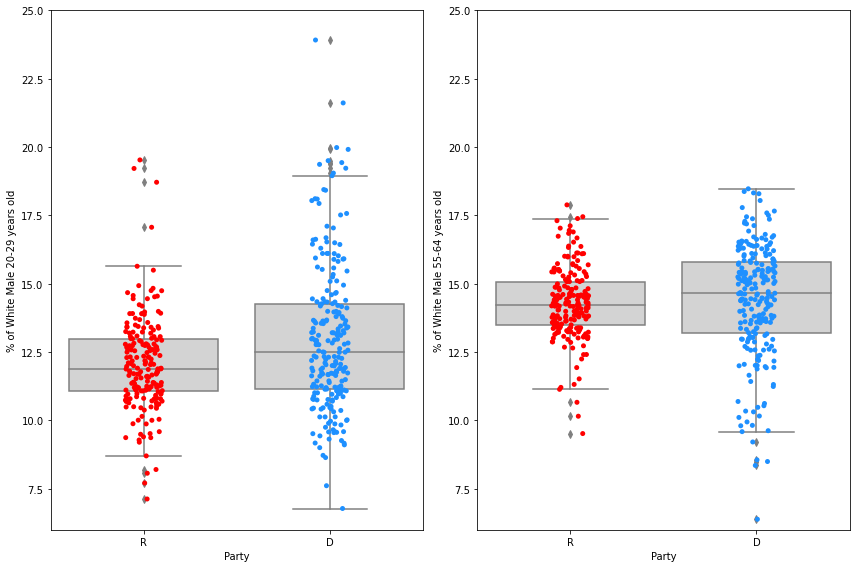

In [ ]:
# figure size
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# boxplot 
sns.boxplot(x="Party", y="% of White Male 20-29 years old", data=merged_df, color="lightgray", ax=axes[0]).set_ylim(6,25)
sns.boxplot(x="Party", y="% of White Male 55-64 years old", data=merged_df, color="lightgray", ax=axes[1]).set_ylim(6,25)

# setting color for jitter and grid 
colors = ["red", "dodgerblue"]
sns.set_palette(colors)
sns.set_style("whitegrid")

# jitter plot / stripplot
sns.stripplot(x="Party", y="% of White Male 20-29 years old", data=merged_df, ax=axes[0]).set_ylim(6,25)
sns.stripplot(x="Party", y="% of White Male 55-64 years old", data=merged_df, ax=axes[1]).set_ylim(6,25)

# showing the graph
fig.tight_layout()
plt.show()

Side-by-side boxplots were created to compare the distributions between the younger and older white males. The y-axis indicates the percentage of white males for the younger generations and for the older generations. The x-axis illustrates the two political districts: Republican and Democratic. The boxplot reveals the medians for younger and older white males are similar for both political districts. Additionally, the boxplots reveal that the median values are similar within the same generations for each political area. The Democratic district has a more extensive spread than the Republican for younger and older white males. 

In general, there is a higher percentage of older white males in both political areas. Within the younger generations, there are more outliers for both districts, increasing the variability. In contrast, the older generations are more consistent due to fewer outliers. 


### Bar Graph

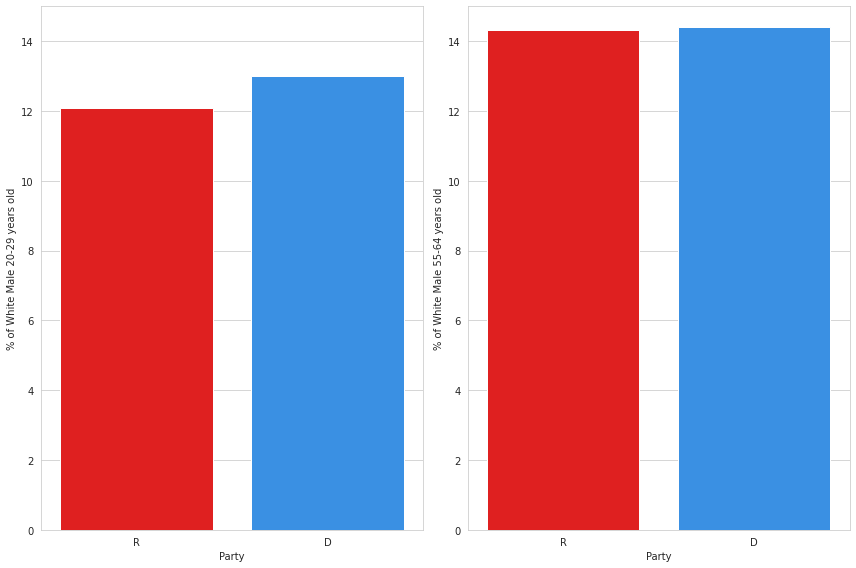

In [ ]:
# figure size
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# setting color for bar graph
colors = ["red", "dodgerblue"]
sns.set_palette(colors)
sns.set_style("whitegrid")

# bar graph
sns.barplot(x="Party", y="% of White Male 20-29 years old", data=merged_df, ax=axes[0], ci= None).set_ylim(0,15) 
sns.barplot(x="Party", y="% of White Male 55-64 years old", data=merged_df, ax=axes[1], ci= None).set_ylim(0,15) 

# showing the graph
fig.tight_layout()
plt.show()

Bar graphs were constructed to compare the percentages for each political area. Illustrated in the graph, within the older generations, there is not a significant difference in whether they live in Democratic or Republic districts. However, within the younger generations, there is a greater amount that tends to live in democratic districts. 


# **Statistical Analysis**

## Older White Males

**Null Hypothesis**: The mean percent of older white males in Democratic districts is equal to the mean percent of older white males in Republican districts 

**Alternative Hypothesis**: The mean percent of older white males is not equal in Democratic and Republican districts



In [ ]:
# Democratic District
groupD = merged_df[merged_df['Party']=='D']
groupD_Y = groupD[['Party', '% of White Male 20-29 years old']]
groupD_O = groupD[['Party', '% of White Male 55-64 years old']]

# Republican District
groupR = merged_df[merged_df['Party']=='R']
groupR_Y = groupR[['Party', '% of White Male 20-29 years old']]
groupR_O = groupR[['Party', '% of White Male 55-64 years old']]

# Comparing Democratic and Republican Districts for Percent of Older White Males
ttest_ind(groupD_O["% of White Male 55-64 years old"], groupR_O["% of White Male 55-64 years old"])


Ttest_indResult(statistic=0.5176145488785472, pvalue=0.604992175706961)

After conducting a two-sample t-test comparing the mean percent of older white males for Democratic and Republican districts, the test statistic resulted in a value of approximately 0.5176 and the p-value concluded to be about 0.605. Due to the large p-value, we fail to reject the null hypothesis and cannot conclude that there is a difference in percentage of older white males for Republican and Democratic districts. This conclusion supports the analysis completed in the data visualization section of this notebook.

## Younger White Males

**Null Hypothesis**: The mean percent of younger white males in Democratic districts is equal to the mean percent of older white males in Republican districts 

**Alternative Hypothesis**: The mean percent of younger white males is not equal in Democratic and Republican districts

In [ ]:
ttest_ind(groupD_Y["% of White Male 20-29 years old"], groupR_Y["% of White Male 20-29 years old"])

Ttest_indResult(statistic=4.176094157753062, pvalue=3.589009692120887e-05)

After conducting a two-sample t-test comparing the mean percent of older white males for Democratic and Republican districts, the test statistic resulted in a value of approximately 4.176 and the p-value concluded to be about 3.589e-05. Due to the small p-value, we reject the null hypothesis and conclude that there is a difference in percentage of younger white males for Republican and Democratic districts. Since this analysis only tests whether there is a difference, a one-sided t-test is conducted below to understand the direction of the difference.

**Null Hypothesis**: The mean percent of younger white males in democratic districts is less than the mean percent of younger white males in Republican districts 

**Alternative Hypothesis**: The mean percent of younger white males in democratic districts is greater than the mean percent of younger white males in Republican districts 

In [ ]:
ttest_ind(groupD_Y["% of White Male 20-29 years old"], groupR_Y["% of White Male 20-29 years old"], alternative = "greater")

Ttest_indResult(statistic=4.176094157753062, pvalue=1.7945048460604434e-05)

After conducting a two-sample one-sided t-test to test if mean perecent of younger white males for Democratic districts is greater than Republican districts, the test statistic resulted in a value of approximately 0.4176 and the p-value concluded to be about 1.7945e-05. The small p-value indicates that we reject the null hypothesis and conclude that the mean percentage of younger white males in democratic districts is greater than the mean percentage of younger white males in Republican districts. This conclusion is consistent with the analysis found in the data visualization section of this notebook.


# **Conclusion**

In conclusion, the visualizations of the data revealed similar median percentages of ages for Democratic and Republican districts within each of the generations. The bar graphs revealed within the older generations, there is not a significant difference in whether they live in Democratic or Republic districts. However, within the younger generations, there is a greater amount that tends to live in democratic districts. 

Statistical analyses were computed based on the findings in the visualizations. A two-sided t-test was conducted to compare the mean difference of the percentage of older white males in Democratic and Republican districts. The result of the statistical analysis is consistent with the findings from the visualizations. That is, there is not enough evidence to conclude that there is a difference in percentage of older white males in political districts. Additionally, a one-sided t-test was conducted to test if the mean percentage of younger white males for Democratic districts is greater than Republican districts. The results indicated that there is a greater mean percentage of younger white males in Democratic districts than in the Republic. 

The analysis supports part of our initial hypothesis: that in general, more younger white males live in Democratic districts. However, there is not enough evidence to support the other part of the hypothesis: that in general, more older white males live in Republican districts. Further analysis that could be explored include integrating additional age categories, expanding the analysis to other races, or incorporating females.



## **Sources**
U.S. Census Bureau About White Males (https://www.visualcapitalist.com/visualizing-u-s-population-by-race/) 

Census Data for the Ages Groups for White Males, District Number, State
(https://api.census.gov/data/2021/acs/acs1?get=NAME,B01001A_002E,B01001A_008E,B01001A_012E&for=congressional%20district:*&in=state)

Data for Political Affiliation
(http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv) 
